# **MRI Brain Alzheimer Classification - Dino V2 attacked**

**Clone Dataset from GitHub**

In [1]:
# Check if the directory exists and clone if it does not
# !if [ ! -d "MRI_Brain_Alzheimer_Classification" ]; then git clone https://github.com/nivbartov/MRI_Brain_Alzheimer_Classification; fi

# Change directory to the cloned repository
# %cd MRI_Brain_Alzheimer_Classification
%cd ..

c:\Dor\TECHNION\deep_learning\Project\MRI_Barin_Alzheimer_Classification


**Import Packages**

In [3]:
import warnings
# Suppress user and future warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# imports
import sys
import os
import numpy as np
import pandas as pd
import torch
import torchattacks
from torchsummary import summary
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset, ConcatDataset
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from kornia import augmentation as K
from kornia.augmentation import AugmentationSequential
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import random
import time
import json
import gc
import subprocess


# repository imports
from models import def_models
from utils import utils_funcs
from utils import optuna_search


**Device Definition**

In [4]:
# check if there is a CUDA device available 
print(f'torch.cuda.is_available(): {torch.cuda.is_available()}')

# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')
torch.cuda.empty_cache()
gc.collect()
print(torch.cuda.memory_summary())
utils_funcs.open_nvitop()

torch.cuda.is_available(): True
device: cuda:0
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from larg

**Load the Dataset**

In [5]:
train_set = torch.load('dataset/dataset_variables/train_set.pt')
validation_set = torch.load('dataset/dataset_variables/validation_set.pt')
test_set = torch.load('dataset/dataset_variables/test_set.pt')

**Model Definition and Initialization**

In [7]:
# Initialize in,out channels, width and height sizes
input_channels = 3
width = 224
height = 224
output_channels = 4

dino_v2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

# freeze dino_v2 layers
for param in dino_v2_model.parameters():
    param.requires_grad = False
    

# make the model
model = def_models.DINO_v2_FT(dino_backbone=dino_v2_model, output_channels=output_channels).to(device)

Using cache found in C:\Users\97252/.cache\torch\hub\facebookresearch_dinov2_main


**Pre-processing of the data**

In [6]:
# Resize images from 128x128 to 224x224 transformation
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Apply transformations to the datasets
train_set = utils_funcs.apply_transformations(train_set, preprocess)
validation_set = utils_funcs.apply_transformations(validation_set, preprocess)
test_set = utils_funcs.apply_transformations(test_set, preprocess)

**Model Statistics**

In [8]:
# model statistics
model_name = type(model).__name__
print("model ", model_name," statistics")
summary(model, (input_channels, height, width))

total_params = sum(p.numel() for p in model.parameters())

print(f"Total parameters: {total_params}")

model  DINO_v2_FT  statistics
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 384, 16, 16]         226,176
          Identity-2             [-1, 256, 384]               0
        PatchEmbed-3             [-1, 256, 384]               0
         LayerNorm-4             [-1, 257, 384]             768
            Linear-5            [-1, 257, 1152]         443,520
            Linear-6             [-1, 257, 384]         147,840
           Dropout-7             [-1, 257, 384]               0
   MemEffAttention-8             [-1, 257, 384]               0
        LayerScale-9             [-1, 257, 384]               0
        LayerNorm-10             [-1, 257, 384]             768
           Linear-11            [-1, 257, 1536]         591,360
             GELU-12            [-1, 257, 1536]               0
          Dropout-13            [-1, 257, 1536]               0
         

**Hyper Parameters**

In [9]:
op_tuna_params_path = f'./checkpoints/op_tuna_params/{model_name}/DINO_v2_FT_0.8922.json'

print("Retrieving op_tuna params...")

with open(op_tuna_params_path, 'r') as file:
    params = json.load(file)

# Hyper-parameters
batch_size = params['batch_size']
learning_rate = params['lr']
optimizer_name = params['optimizer']

print(f'Batch Size: {batch_size}')
print(f'Learning Rate: {learning_rate}')
print(f'Optimizer Name: {optimizer_name}')

# loss criterion
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = getattr(torch.optim, optimizer_name)(model.fc.parameters(), lr=learning_rate)


Retrieving op_tuna params...
Batch Size: 128
Learning Rate: 0.0003168846480451579
Optimizer Name: Adam


**Use the pretrained fine-tuned dino_v2 model**

In [10]:
pretrained_model_path = f"./checkpoints/{model_name}_074007_01102024.pth"
checkpoint = torch.load(pretrained_model_path,weights_only=True)
last_epoch, last_loss = utils_funcs.load_model(model, optimizer, pretrained_model_path)
model.load_state_dict(checkpoint['net'])

Loaded model from ./checkpoints/DINO_v2_FT_074007_01102024.pth (epoch: 50, loss: 0.0004)


<All keys matched successfully>

**Prepare data for single point attacks**

In [12]:
# test loader witch batch size 1 in order to attack them one by one
testloader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=6, pin_memory=True)

**Perform Fast Gradient Sign Attack(FGSM)**

In [13]:
accuracies = []
examples = []
# epsilons = [0, .0005, .005, .05, .1, .15, .2, .25, .3]
epsilons = [0, .0005, .005]

for eps in epsilons:
    print(f"Attacking using epsilon: {eps}")
    
    acc, ex = utils_funcs.test_single_point_attack(model, device, testloader,'fgsm', eps)
    accuracies.append(acc)
    examples.append(ex)
    
    print(f"Finished attacking with epsilon: {eps}. Accuracy: {acc:.4f}%") 
    
    
utils_funcs.print_accuracy_table(epsilons, accuracies)    

Attacking using epsilon: 0
Finished attacking with epsilon: 0. Accuracy: 94.9219%
Attacking using epsilon: 0.0005
Finished attacking with epsilon: 0.0005. Accuracy: 30.5469%
Attacking using epsilon: 0.005
Finished attacking with epsilon: 0.005. Accuracy: 3.7500%
+---------+----------+
| Epsilon | Accuracy |
+---------+----------+
|    0    | 94.9219% |
|  0.0005 | 30.5469% |
|  0.005  | 3.7500%  |
+---------+----------+


**Attacked images that were classified wrongly using FGSM**

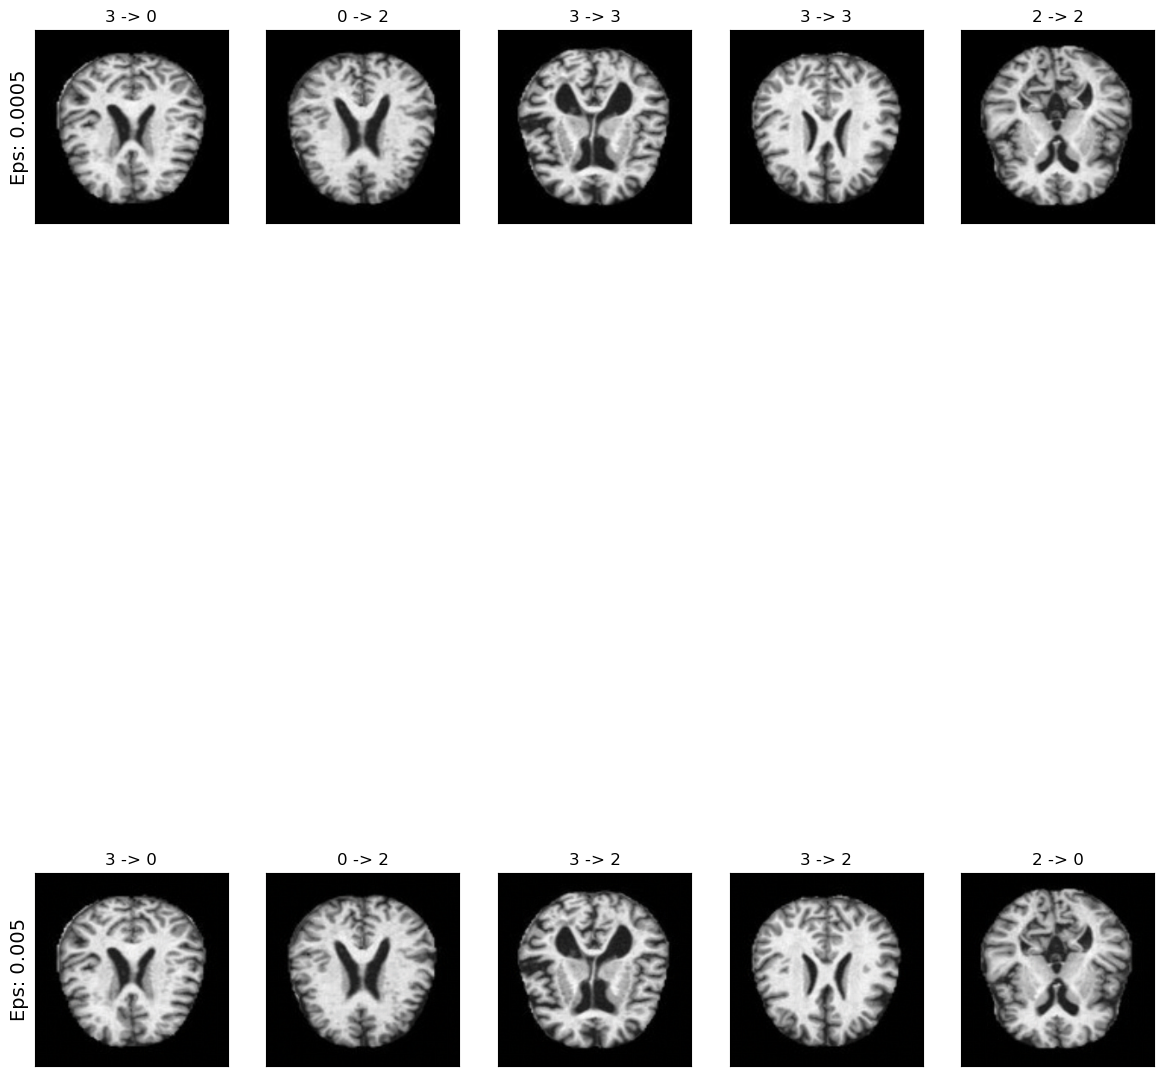

In [14]:
utils_funcs.plot_adversarial_examples(epsilons, examples)

**Perform Projected Gradient Descent(PGD)**

In [14]:
accuracies = []
examples = []

epsilons = [0, .0005, .005]
alpha = 0.3
num_iter = 5

for eps in epsilons:
    print(f"Attacking using epsilon: {eps}")
    
    acc, ex = utils_funcs.test_single_point_attack(model, device, testloader,'pgd', eps, alpha=alpha,num_iter=num_iter)
    accuracies.append(acc)
    examples.append(ex)
    
    torch.cuda.empty_cache()
    gc.collect()
    
    print(f"Finished attacking with epsilon: {eps}. Accuracy: {acc:.4f}%") 
    
    
utils_funcs.print_accuracy_table(epsilons, accuracies)    

Attacking using epsilon: 0
Finished attacking with epsilon: 0. Accuracy: 94.9219%
Attacking using epsilon: 0.0005
Finished attacking with epsilon: 0.0005. Accuracy: 21.7969%
Attacking using epsilon: 0.005
Finished attacking with epsilon: 0.005. Accuracy: 4.2188%
+---------+----------+
| Epsilon | Accuracy |
+---------+----------+
|    0    | 94.9219% |
|  0.0005 | 21.7969% |
|  0.005  | 4.2188%  |
+---------+----------+


**Attacked images that were classified wrongly using PGD**

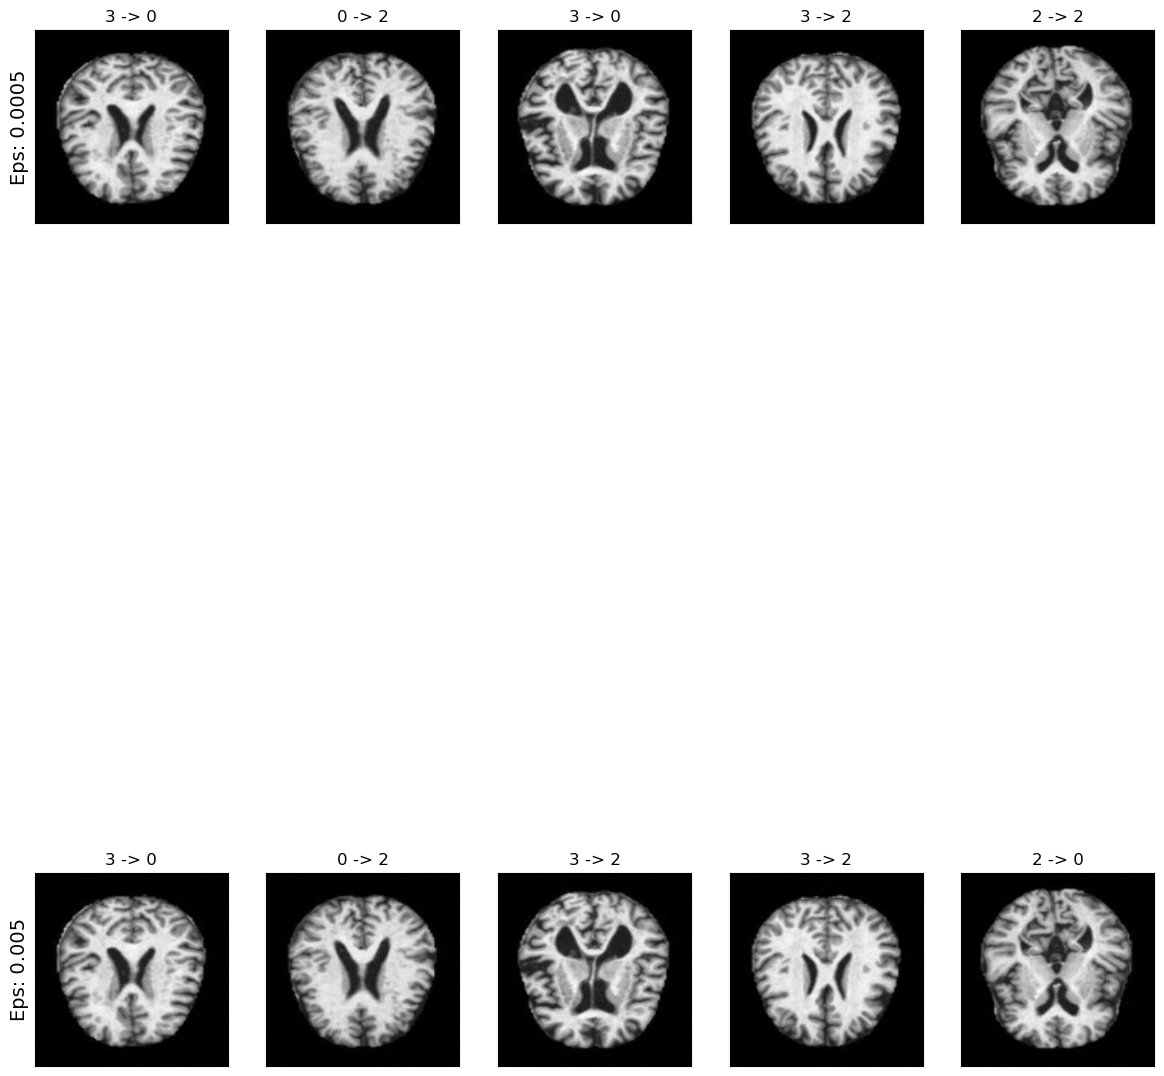

In [15]:
utils_funcs.plot_adversarial_examples(epsilons, examples)

**Optuna**

In [14]:
# TODO: should we use optuna for the adv weight parameter? maybe the epsilon?

**Prepare model before adversial training**

In [16]:
# Hyper-parameters
batch_size = params['batch_size']
learning_rate = params['lr']
optimizer_name = params['optimizer']
epsilon=0.005
adv_weight = 0.5

num_epochs = 2

# loss criterion
criterion = nn.CrossEntropyLoss()

# optimizer
##optimizer = getattr(torch.optim, optimizer_name)(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
optimizer = getattr(torch.optim, optimizer_name)(model.fc.parameters(), lr=learning_rate)

# Combine train_set and val_set into one dataset and
combined_train_val_set = ConcatDataset([train_set, validation_set])

# Loading the data and shuffling it
trainloader = torch.utils.data.DataLoader(combined_train_val_set, batch_size=batch_size, shuffle=True, num_workers=6,pin_memory=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=6,pin_memory=True)


**Adversial train model**

In [17]:
epoch_losses = utils_funcs.adversarial_train(model, num_epochs, trainloader, device, criterion,
                                             optimizer, attack_type='pgd', epsilon=epsilon, adv_weight=adv_weight, alpha=alpha, num_iter=num_iter)

Adversarial Training model: DINO_v2_FT on cuda:0 with PGD attack and adversarial weight 0.5
Epoch: 1 | Loss: 1.3730 | Training Accuracy: 74.805% | Epoch Time: 1953.00 secs
Epoch: 2 | Loss: 0.6039 | Training Accuracy: 81.016% | Epoch Time: 2273.72 secs


**Results**

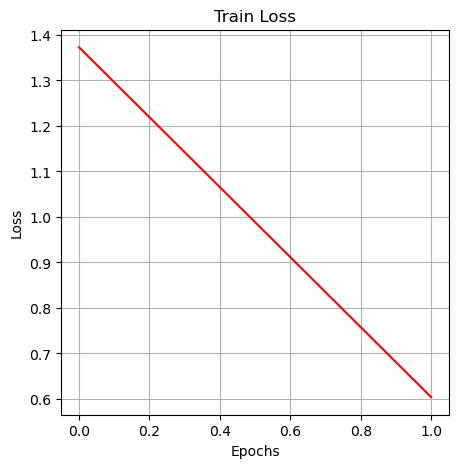

In [18]:
utils_funcs.plot_loss_curve(epoch_losses, num_epochs)

In [19]:

# pretrained_model_path = f"./checkpoints/adv_attk_DINO_v2_FT_213025_30092024.pth"
# checkpoint = torch.load(pretrained_model_path,weights_only=True)
# last_epoch, last_loss = utils_funcs.load_model(model, optimizer, pretrained_model_path)
# model.load_state_dict(checkpoint['net'])

test_accuracy_adversial_attk = utils_funcs.calculate_accuracy_attack(model, testloader,device,attack_type='fgsm',epsilon=epsilon)
print("Test accuracy on adversial attacks: {:.3f}%".format(test_accuracy_adversial_attk))

test_accuracy = utils_funcs.calculate_accuracy(model, testloader, device)
print("Test accuracy: {:.3f}%".format(test_accuracy))



Test accuracy on adversial attacks: 36.875%
Test accuracy: 72.109%
